In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torch
import os
import glob
from torch import nn
from torch.optim import Adam
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, coo_matrix
from joblib import Parallel, delayed

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
transactions = pd.read_csv('./dataset/cleaned_dataset/cleaned_transactions.csv')
customer_map = {customer: idx for idx, customer in enumerate(transactions['customer_id'].unique())}
transactions['article_id'] = transactions['article_id'].astype(str).str.zfill(10)
article_map = {article: idx for idx, article in enumerate(transactions['article_id'].unique())}

transactions['customer_idx'] = transactions['customer_id'].map(customer_map)
transactions['article_idx'] = transactions['article_id'].map(article_map)

user_item_sparse = csr_matrix(
    (np.ones(len(transactions)), (transactions['customer_idx'], transactions['article_idx'])),
    shape=(len(customer_map), len(article_map))
)

In [7]:
user_factors = np.load('./models/user_factors.npy')
item_factors = np.load('./models/item_factors.npy')

def get_svd_recommendations(user_id, top_n=10):
    if user_id not in customer_map:
        print("User ID not found.")
        return []
    
    user_idx = customer_map[user_id]
    user_vector = user_factors[user_idx, :]
    user_ratings = np.dot(user_vector, item_factors)
    top_articles = np.argsort(user_ratings)[-top_n:]
    return [list(article_map.keys())[idx] for idx in top_articles[::-1]]

In [8]:
als_user_factors = torch.load("./models/als_user_factors.pth").to(device)
als_item_factors = torch.load("./models/als_item_factors.pth").to(device)

def get_als_recommendations(user_id, top_n=10):
    if user_id not in customer_map:
        print("User ID not found.")
        return []
    
    user_idx = customer_map[user_id]
    user_vector = als_user_factors[user_idx]
    scores = torch.matmul(user_vector, als_item_factors.T)
    top_items = torch.argsort(scores, descending=True)[:top_n]
    return [list(article_map.keys())[idx] for idx in top_items.cpu().numpy()]

In [9]:
IMAGE_DIR = "./dataset/h&m/images/"

In [10]:
def find_image(article_id):
    folder = article_id[:3]  # First 3 characters of article_id as folder
    image_path_pattern = os.path.join(IMAGE_DIR, folder, f"{article_id}.*")
    image_files = glob.glob(image_path_pattern)
    return image_files[0] if image_files else None

In [11]:
def show_recommended_images(user_id, model_type='svd', num_images=10):
    if model_type == 'svd':
        recommended_articles = get_svd_recommendations(user_id, num_images)
    else:
        recommended_articles = get_als_recommendations(user_id, num_images)
    
    if not recommended_articles:
        print("No recommendations found.")
        return
    
    fig, axes = plt.subplots(1, len(recommended_articles), figsize=(15, 5))
    if len(recommended_articles) == 1:
        axes = [axes]
    
    for ax, article_id in zip(axes, recommended_articles):
        image_path = find_image(article_id)
        if image_path:
            img = Image.open(image_path)
            ax.imshow(img)
            ax.set_title(f"Article {article_id}")
            ax.axis("off")
        else:
            ax.set_title(f"Image Not Found\n{article_id}")
            ax.axis("off")
    
    plt.show()

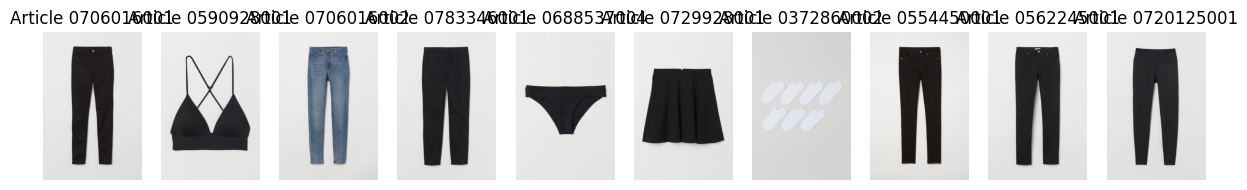

In [12]:
user_id = list(customer_map.keys())[5]
show_recommended_images(user_id, model_type='svd')

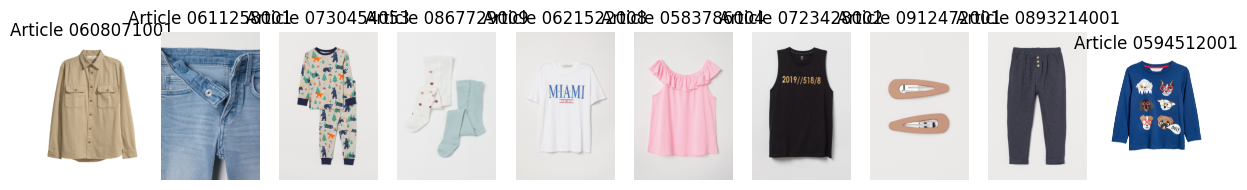

In [13]:
user_id = list(customer_map.keys())[5]
show_recommended_images(user_id, model_type='als')